In [1]:
# ==============================
# 1. Setup, Installation, and Imports
# ==============================

# Install necessary machine learning packages
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
# ==============================
# 2. Import Libraries
# ==============================
import pandas as pd
import numpy as np
import os
import joblib
from datetime import datetime, timedelta

# Machine Learning Models
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import Lasso # We will still define it for comparison, but won't use it now.

# ML Utilities and Metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline # For Lasso/Scaling if needed

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==============================
# 3. Data Loading and Initial Preprocessing
# ==============================
file_path = 'retail_store_inventory final.csv'

if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' was not found.")
    print("Please upload the CSV file to your environment.")
else:
    try:
        raw_df = pd.read_csv(file_path)
        print(f"File '{file_path}' loaded successfully. Shape: {raw_df.shape}")

        # --- Date Conversion ---
        raw_df['Date'] = pd.to_datetime(raw_df['Date'])
        print("Date column converted to datetime objects.")

        # --- Self-Contained Label Encoding ---
        print("\n--- Applying Label Encoding to IDs ---")

        # Store and save label encoders for Store ID
        le_store = LabelEncoder()
        raw_df['Store ID_encoded'] = le_store.fit_transform(raw_df['Store ID'])

        # Store and save label encoders for Product ID
        le_product = LabelEncoder()
        raw_df['Product ID_encoded'] = le_product.fit_transform(raw_df['Product ID'])

        # Save the encoders for future prediction use
        joblib.dump(le_store, 'le_store.pkl')
        joblib.dump(le_product, 'le_product.pkl')

        # We also need to label encode the 'Category' column for LightGBM's native categorical handling
        le_category = LabelEncoder()
        raw_df['Category_encoded'] = le_category.fit_transform(raw_df['Category'])
        joblib.dump(le_category, 'le_category.pkl')

        print("✅ Label encoders for 'Store ID', 'Product ID', and 'Category' created and saved.")
        print(f"First 5 rows of data:\n{raw_df.head()}")

    except Exception as e:
        print(f"Error loading or processing the CSV file: {e}")

File 'retail_store_inventory final.csv' loaded successfully. Shape: (73100, 15)
Date column converted to datetime objects.

--- Applying Label Encoding to IDs ---
✅ Label encoders for 'Store ID', 'Product ID', and 'Category' created and saved.
First 5 rows of data:
        Date Store ID Product ID     Category Region  Inventory Level  \
0 2022-01-01     S001      P0001    Groceries  North              231   
1 2022-01-01     S001      P0002         Toys  South              204   
2 2022-01-01     S001      P0003         Toys   West              102   
3 2022-01-01     S001      P0004         Toys  North              469   
4 2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164   

In [3]:
# ==============================
# 4. Hyper-Minimal Feature Engineering Class
# ==============================
class FeatureGenerator:
    """
    Generates a hyper-minimal set of high-impact features for robust forecasting.
    Focuses on core time, lag (1, 7, 30), and rolling mean (30) features.
    """
    def __init__(self, df):
        self.df = df.copy()

        # --- Drop external/future-dependent columns ---
        # Corrected column names to match raw_df and added 'Units Ordered'
        columns_to_drop = [
            'Region', 'Demand Forecast', 'Weather Condition',
            'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'Units Ordered'
        ]
        self.df = self.df.drop(columns=columns_to_drop, errors='ignore')
        print(f"Dropped external/future-dependent columns: {columns_to_drop}")


    def generate_features(self):
        print("\n--- Starting Hyper-Minimal Feature Generation (V3) ---")

        # Sort data first for rolling/lag features
        self.df = self.df.sort_values(['Store ID', 'Product ID', 'Date']).reset_index(drop=True)

        # [cite_start]Handle outliers [cite: 64-68]
        Q1 = self.df['Units Sold'].quantile(0.25)
        Q3 = self.df['Units Sold'].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + (1.5 * IQR)
        self.df['Units Sold'] = self.df['Units Sold'].clip(upper=upper_bound)
        print(f"Capped target outliers at {upper_bound:.0f} units")

        # Group data for grouped operations
        grouped = self.df.groupby(['Store ID', 'Product ID'])

        # --- 1. Temporal Features (Minimal Set) ---
        print("Step 1: Creating core temporal features...")
        self.df['day_of_week'] = self.df['Date'].dt.dayofweek
        self.df['month'] = self.df['Date'].dt.month
        self.df['year'] = self.df['Date'].dt.year
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)

        # --- 2. Cyclical Encoding (Minimal Set) ---
        print("Step 2: Creating core cyclical features...")
        # Only keep Month Sin/Cos for yearly seasonality
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'] / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'] / 12)

        # --- 3. Sales Lag Features (Minimal Set) ---
        print("Step 3: Creating core lag features (1, 7, 30 days)...")
        # Keeping Lag 1 is critical for time-series momentum
        for lag in [1, 7, 30]:
            self.df[f'sales_lag_{lag}'] = grouped['Units Sold'].shift(lag)

        # --- 4. Rolling Window Features (Minimal Set) ---
        print("Step 4: Creating core rolling statistics (Mean 30 days)...")
        shifted_sales = grouped['Units Sold'].shift(1)
        # Rolling Mean 30 is the best long-term trend indicator
        self.df[f'sales_rolling_mean_30'] = shifted_sales.rolling(30, min_periods=1).mean()

        # --- 5. Business & Inventory Features (Minimal Set) ---
        print("Step 5: Creating core business features...")
        # Keep original Price, Discount, Inventory Level
        self.df['effective_price'] = self.df['Price'] * (1 - self.df['Discount'] / 100) # Keep effective price as it combines two variables

        # Only keep one single stock category for OHE simplicity
        self.df['stock_category_simple'] = pd.cut(
            self.df['Inventory Level'],
            bins=[0, 50, 200, np.inf],
            labels=['critical_low', 'medium', 'high'],
            right=False, include_lowest=True
        ).astype(str)

        # --- 6. Clean up ---
        print("\nStep 6: Final cleanup...")
        initial_rows = len(self.df)
        self.df.dropna(inplace=True)
        print(f"   Removed {initial_rows - len(self.df)} rows with NaN values (due to lags/rolling windows)")
        print(f"\n ✅ Feature engineering complete! Final shape: {self.df.shape}")

        return self.df

# --- Feature Generator Execution ---
print("\n" + "="*50)
print(" EXECUTING FEATURE ENGINEERING PIPELINE ")
print("="*50)
generator = FeatureGenerator(raw_df)
final_df = generator.generate_features()

# Store product and store IDs for easy use later
PRODUCT_IDS = final_df['Product ID'].unique()
STORE_IDS = final_df['Store ID'].unique()


 EXECUTING FEATURE ENGINEERING PIPELINE 
Dropped external/future-dependent columns: ['Region', 'Demand Forecast', 'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing', 'Seasonality', 'Units Ordered']

--- Starting Hyper-Minimal Feature Generation (V3) ---
Capped target outliers at 434 units
Step 1: Creating core temporal features...
Step 2: Creating core cyclical features...
Step 3: Creating core lag features (1, 7, 30 days)...
Step 4: Creating core rolling statistics (Mean 30 days)...
Step 5: Creating core business features...

Step 6: Final cleanup...
   Removed 3000 rows with NaN values (due to lags/rolling windows)

 ✅ Feature engineering complete! Final shape: (70100, 23)


In [4]:
# ==============================
# 5. Final Data Preparation and Splitting
# ==============================

# 1. Prepare Categorical Features for Model Splits
# The generator only created 'stock_category_simple', 'Category', and the IDs.

# Define the set of categorical features we need to handle (excluding the already encoded IDs)
categorical_cols = ['Category', 'stock_category_simple']

# 2. Define the Target and Feature Matrix (using the minimal features)
TARGET = 'Units Sold'
X_base = final_df.drop(columns=[TARGET, 'Date', 'Store ID', 'Product ID'], errors='ignore')
y = final_df[TARGET]


# --- Model 1: Data for XGBoost (Requires OHE) ---
print("\n--- Preparing Data for XGBoost (Requires OHE) ---")

# OHE is performed on 'Category' and 'stock_category_simple'
X_xgb = pd.get_dummies(X_base, columns=categorical_cols, drop_first=True)

# Define the final feature list for XGBoost
FINAL_FEATURE_COLUMNS_XGB = X_xgb.columns.tolist()
print(f"Total features for XGBoost (OHE): {len(FINAL_FEATURE_COLUMNS_XGB)}")


# --- Model 2: Data for LightGBM (Requires Label/Integer Encoding) ---
print("\n--- Preparing Data for LightGBM (Requires Integer Encoding) ---")

# For LightGBM, we use the Label Encoded 'Category_encoded' from Cell 2, and Label Encode the new 'stock_category_simple'
X_lgb = X_base.copy()

# Drop the original 'Category' column since we use 'Category_encoded'
X_lgb = X_lgb.drop(columns=['Category'], errors='ignore')

# Label Encode the generated 'stock_category_simple' for LighGBM
le_stock = LabelEncoder()
X_lgb['stock_category_simple_encoded'] = le_stock.fit_transform(X_lgb['stock_category_simple'])
X_lgb = X_lgb.drop(columns=['stock_category_simple'], errors='ignore')

# Define the final feature list for LightGBM
FINAL_FEATURE_COLUMNS_LGB = X_lgb.columns.tolist()
print(f"Total features for LightGBM (Integer Encoded): {len(FINAL_FEATURE_COLUMNS_LGB)}")


# 3. Use a robust time-based split (80% Train, 20% Test)
print("\n--- Splitting data chronologically (80% Train / 20% Test) ---")
split_index = int(len(final_df) * 0.8)

# Split data for XGBoost
X_train_xgb = X_xgb.iloc[:split_index]
X_test_xgb = X_xgb.iloc[split_index:]

# Split data for LightGBM
X_train_lgb = X_lgb.iloc[:split_index]
X_test_lgb = X_lgb.iloc[split_index:]

# Split target variable
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"XGBoost Train set: {X_train_xgb.shape} | LightGBM Train set: {X_train_lgb.shape}")
print(f"Test set size: {X_test_xgb.shape}")


--- Preparing Data for XGBoost (Requires OHE) ---
Total features for XGBoost (OHE): 22

--- Preparing Data for LightGBM (Requires Integer Encoding) ---
Total features for LightGBM (Integer Encoded): 18

--- Splitting data chronologically (80% Train / 20% Test) ---
XGBoost Train set: (56080, 22) | LightGBM Train set: (56080, 18)
Test set size: (14020, 22)


In [5]:
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# NOTE: Assumes X_train_xgb, X_test_xgb, X_train_lgb, X_test_lgb, y_train, y_test,
# FINAL_FEATURE_COLUMNS_XGB, and FINAL_FEATURE_COLUMNS_LGB are defined from the previous cell.

# Hyperparameter Grid (Simplified and shared for fair comparison)
param_grid = {
    'n_estimators': [150, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
cv_split = TimeSeriesSplit(n_splits=4)

# --- A. LIGHTGBM MODEL (Primary Candidate) ---
print("\n--- Starting GridSearchCV for LightGBM ---")

# LightGBM Estimator Setup
lgb_estimator = lgb.LGBMRegressor(random_state=42, metric='rmse', n_jobs=-1, verbose=-1)

grid_search_lgb = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv_split,
    verbose=0,
    n_jobs=-1
)

# Fit on LightGBM's integer-encoded training data
grid_search_lgb.fit(X_train_lgb, y_train)
best_lgb_model = grid_search_lgb.best_estimator_

print(" LightGBM GridSearchCV completed.")
print(f"LGB Best RMSE from CV: {-grid_search_lgb.best_score_:.2f}")

# Save the best trained LightGBM model
model_filename_lgb = 'best_lgb_model.pkl'
joblib.dump(best_lgb_model, model_filename_lgb)
print(f"✅ LightGBM Model successfully saved to '{model_filename_lgb}'")

# --- B. XGBOOST MODEL (Comparison) ---
print("\n--- Starting GridSearchCV for XGBoost ---")

grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv_split,
    verbose=0,
    n_jobs=-1
)

# Fit on XGBoost's OHE training data
grid_search_xgb.fit(X_train_xgb, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

print(" XGBoost GridSearchCV completed.")
print(f"XGB Best RMSE from CV: {-grid_search_xgb.best_score_:.2f}")

# Save the best trained XGBoost model
model_filename_xgb = 'best_xgb_model_comp.pkl'
joblib.dump(best_xgb_model, model_filename_xgb)

# --- C. FINAL PERFORMANCE EVALUATION AND COMPARISON ---

# 1. Predict and Evaluate LightGBM
y_test_pred_lgb = best_lgb_model.predict(X_test_lgb)
test_mae_lgb = mean_absolute_error(y_test, y_test_pred_lgb)
test_rmse_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
test_r2_lgb = r2_score(y_test, y_test_pred_lgb)

# 2. Predict and Evaluate XGBoost
y_test_pred_xgb = best_xgb_model.predict(X_test_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

# 3. Comparison Table
comparison_data = {
    'Model': ['LightGBM Regressor', 'XGBoost Regressor'],
    'MAE (Test)': [test_mae_lgb, test_mae_xgb],
    'RMSE (Test)': [test_rmse_lgb, test_rmse_xgb],
    'R² (Test)': [test_r2_lgb, test_r2_xgb]
}
comparison_df = pd.DataFrame(comparison_data).set_index('Model').round(4)

print("\n" + "="*70)
print(" FINAL MODEL COMPARISON (TEST SET PERFORMANCE)")
print("="*70)
print(comparison_df.to_string())
print("="*70)


--- Starting GridSearchCV for LightGBM ---
 LightGBM GridSearchCV completed.
LGB Best RMSE from CV: 88.00
✅ LightGBM Model successfully saved to 'best_lgb_model.pkl'

--- Starting GridSearchCV for XGBoost ---
 XGBoost GridSearchCV completed.
XGB Best RMSE from CV: 88.02

 FINAL MODEL COMPARISON (TEST SET PERFORMANCE)
                    MAE (Test)  RMSE (Test)  R² (Test)
Model                                                 
LightGBM Regressor     69.0314      88.0574     0.3479
XGBoost Regressor      69.0519      88.0477     0.3481


In [6]:
# ==============================
# 7. Dynamic Forecasting Manager Class (CORRECTED AGAIN)
# ==============================

class ForecastingManager:
    """
    Manages dynamic forecasting for single or batch products across variable horizons (7, 14, 30, 90 days).
    Uses the trained LightGBM model.
    """
    def __init__(self, model, feature_columns, historical_df, le_product, le_store, le_category):
        self.model = model
        self.feature_columns = feature_columns
        self.historical_df = historical_df.copy()
        self.le_product = le_product
        self.le_store = le_store
        self.le_category = le_category

        self.latest_date = self.historical_df['Date'].max()
        max_lookback = 30
        self.lookback_df = self.historical_df[
            self.historical_df['Date'] >= (self.latest_date - pd.Timedelta(days=max_lookback))
        ].sort_values('Date').reset_index(drop=True)

        print(f"Forecasting Manager Initialized. Latest historical date: {self.latest_date.strftime('%Y-%m-%d')}")

    def _get_product_context(self, product_id):
        """
        Extracts fixed context (Store ID, Price, Inventory, Category) for a product
        **using only the columns GUARANTEED to exist** in the cleaned final_df.
        """

        # Get the single most recent row for the product
        context = self.historical_df[
            (self.historical_df['Product ID'] == product_id) &
            (self.historical_df['Date'] == self.latest_date)
        ]

        if context.empty:
            context = self.historical_df[self.historical_df['Product ID'] == product_id].tail(1)

        if context.empty:
            raise ValueError(f"Product ID '{product_id}' not found in historical data.")

        last_data = context.iloc[0]

        # --- CORRECTION: ONLY INCLUDE FEATURES GUARANTEED TO EXIST and needed for future feature generation---
        return {
            'Store ID': last_data['Store ID'],
            'Price': last_data['Price'],
            'Discount': last_data['Discount'],
            'Inventory Level': last_data['Inventory Level'],
            'Category': last_data['Category'],
            'Store ID_encoded': last_data['Store ID_encoded'],
            'Product ID_encoded': last_data['Product ID_encoded'],
            'Category_encoded': last_data['Category_encoded'],
        }

    def _generate_future_features(self, product_id, horizon_days):
        """Generates all feature rows recursively, predicting day-by-day."""

        context = self._get_product_context(product_id)

        start_date = self.latest_date + pd.Timedelta(days=1)
        date_range = pd.date_range(start=start_date, periods=horizon_days, freq='D')

        future_data = pd.DataFrame({'Date': date_range})

        # Populate static features (assumed constant for the forecast period)
        future_data['Store ID'] = context['Store ID']
        future_data['Product ID'] = product_id
        future_data['Store ID_encoded'] = context['Store ID_encoded']
        future_data['Product ID_encoded'] = context['Product ID_encoded']
        future_data['Category_encoded'] = context['Category_encoded']

        # Input features that are fixed for the forecast horizon (and are model features)
        future_data['Price'] = context['Price']
        future_data['Discount'] = context['Discount']
        future_data['Inventory Level'] = context['Inventory Level']

        # --- Create Temporal and Derived Features ---
        future_data['day_of_week'] = future_data['Date'].dt.dayofweek
        future_data['month'] = future_data['Date'].dt.month
        future_data['year'] = future_data['Date'].dt.year
        future_data['is_weekend'] = (future_data['day_of_week'] >= 5).astype(int)
        future_data['month_sin'] = np.sin(2 * np.pi * future_data['month'] / 12)
        future_data['month_cos'] = np.cos(2 * np.pi * future_data['month'] / 12)
        future_data['effective_price'] = future_data['Price'] * (1 - future_data['Discount'] / 100)

        # Simplified Stock Category (replicate generator logic)
        future_data['stock_category_simple'] = pd.cut(
            future_data['Inventory Level'],
            bins=[0, 50, 200, np.inf],
            labels=['critical_low', 'medium', 'high'],
            right=False, include_lowest=True
        ).astype(str)

        # Apply Label Encoding to the generated stock category
        known_stock_classes = ['critical_low', 'medium', 'high']
        le_stock_future = LabelEncoder().fit(known_stock_classes)
        future_data['stock_category_simple_encoded'] = le_stock_future.transform(future_data['stock_category_simple'])

        # --- Initialize Lag and Rolling Mean Features with NaNs/zeros ---
        # These are dynamically calculated later in forecast_single_product but must be present as columns.
        for col in ['sales_lag_1', 'sales_lag_7', 'sales_lag_30', 'sales_rolling_mean_30']:
            if col in self.feature_columns:
                future_data[col] = np.nan # Initialize with NaN, will be filled during recursive prediction

        # Drop auxiliary columns not in the LGB feature list before selecting final features
        cols_to_drop_from_future_data = [
            'Date', 'Store ID', 'Product ID', 'Category', 'stock_category_simple'
        ]
        X_final_features = future_data.drop(columns=cols_to_drop_from_future_data, errors='ignore')

        # Ensure the order of columns matches the model's expected feature_columns
        X_final_features = X_final_features[self.feature_columns.copy()]

        return X_final_features, future_data[['Date', 'Store ID', 'Product ID']]


    def forecast_single_product(self, product_id, horizon_days):
        """
        Generates a single product forecast using recursive prediction for dynamic features.
        """
        # Generate static and temporal future features. X_final_struct contains placeholders for lags/rolling means.
        X_final_struct, result_template = self._generate_future_features(product_id, horizon_days)

        # Filter historical sales for this product to use for initial lags/rolls
        # Ensure 'Units Sold' is in lookback_df
        sales_history = self.lookback_df[self.lookback_df['Product ID'] == product_id]['Units Sold'].tolist()

        predictions = []

        # --- Recursive Prediction Loop ---
        for i in range(horizon_days):
            X_day = X_final_struct.iloc[[i]].copy()

            # Calculate Lag Features (1, 7, 30 days) using sales_history (actual + previous predictions)
            last_known_sale = sales_history[-1] if sales_history else 0

            # Ensure lag features are added to X_day before passing to predict
            # The feature_columns list in the manager is crucial for correct column alignment
            if 'sales_lag_1' in self.feature_columns:
                X_day['sales_lag_1'] = sales_history[-1] if len(sales_history) >= 1 else last_known_sale
            if 'sales_lag_7' in self.feature_columns:
                X_day['sales_lag_7'] = sales_history[-7] if len(sales_history) >= 7 else last_known_sale
            if 'sales_lag_30' in self.feature_columns:
                X_day['sales_lag_30'] = sales_history[-30] if len(sales_history) >= 30 else last_known_sale

            # Calculate Rolling Mean 30
            if 'sales_rolling_mean_30' in self.feature_columns:
                roll_window = sales_history[-30:] # Use up to last 30 known sales
                X_day['sales_rolling_mean_30'] = np.mean(roll_window) if roll_window else last_known_sale

            # Predict the value for the current day. Crucially, pass only the features the model expects.
            X_input = X_day[self.feature_columns].copy()
            pred_units = self.model.predict(X_input)[0]

            pred_units = max(0, pred_units) # Ensure predictions are non-negative
            predictions.append(pred_units)
            sales_history.append(pred_units) # Append prediction to history for next day's lag calculation

        # Final formatting
        result_template['Predicted Units'] = np.round(predictions, 1)

        return result_template

    def forecast_batch(self, horizon_days):
        """Generates a batch forecast for all products for the specified horizon."""
        all_predictions = []
        unique_products = self.historical_df['Product ID'].unique()

        print(f"Starting batch forecast for {len(unique_products)} products over {horizon_days} days...")

        for product_id in unique_products:
            try:
                forecast_result = self.forecast_single_product(product_id, horizon_days)
                all_predictions.append(forecast_result)
            except ValueError as e:
                print(f"Skipping product {product_id}: {e}")

        if not all_predictions:
             return pd.DataFrame({'Error': ["Batch forecast failed for all products."]})

        return pd.concat(all_predictions, ignore_index=True)

# --- Re-Execution --- Initializing the Forecasting Manager with the updated model and feature columns
forecaster = ForecastingManager(
    model=best_lgb_model,
    feature_columns=FINAL_FEATURE_COLUMNS_LGB,
    historical_df=final_df, # Use final_df which has cleaned sales data and encoded features
    le_product=le_product,
    le_store=le_store,
    le_category=le_category
)

print("\n✅ ForecastingManager class defined and re-initialized with LightGBM model and updated feature list.")

Forecasting Manager Initialized. Latest historical date: 2024-01-01

✅ ForecastingManager class defined and re-initialized with LightGBM model and updated feature list.


In [7]:
sample_product_id = 'P0001'
horizon_days = 7

print(f"Generating {horizon_days}-day forecast for Product ID: {sample_product_id}")

# Call the forecast_single_product method
forecast_p0001_7_days = forecaster.forecast_single_product(sample_product_id, horizon_days)

# Display the resulting DataFrame
print(f"\n7-day forecast for Product ID '{sample_product_id}':")
print(forecast_p0001_7_days)

Generating 7-day forecast for Product ID: P0001

7-day forecast for Product ID 'P0001':
        Date Store ID Product ID  Predicted Units
0 2024-01-02     S001      P0001             98.4
1 2024-01-03     S001      P0001             98.7
2 2024-01-04     S001      P0001             99.1
3 2024-01-05     S001      P0001             97.0
4 2024-01-06     S001      P0001             98.9
5 2024-01-07     S001      P0001             97.2
6 2024-01-08     S001      P0001             99.0


In [8]:
sample_product_id = 'P0002'
horizon_days = 30

print(f"Generating {horizon_days}-day forecast for Product ID: {sample_product_id}")

# Call the forecast_single_product method
forecast_p0002_30_days = forecaster.forecast_single_product(sample_product_id, horizon_days)

# Display the resulting DataFrame
print(f"\n{horizon_days}-day forecast for Product ID '{sample_product_id}':")
print(forecast_p0002_30_days)

Generating 30-day forecast for Product ID: P0002

30-day forecast for Product ID 'P0002':
         Date Store ID Product ID  Predicted Units
0  2024-01-02     S001      P0002             93.6
1  2024-01-03     S001      P0002             92.0
2  2024-01-04     S001      P0002             93.3
3  2024-01-05     S001      P0002             92.3
4  2024-01-06     S001      P0002             92.7
5  2024-01-07     S001      P0002             92.3
6  2024-01-08     S001      P0002             93.3
7  2024-01-09     S001      P0002             92.0
8  2024-01-10     S001      P0002             93.2
9  2024-01-11     S001      P0002             92.0
10 2024-01-12     S001      P0002             92.9
11 2024-01-13     S001      P0002             92.9
12 2024-01-14     S001      P0002             89.7
13 2024-01-15     S001      P0002             92.2
14 2024-01-16     S001      P0002             92.0
15 2024-01-17     S001      P0002             92.3
16 2024-01-18     S001      P0002          

In [9]:
horizon_days = 7

print(f"Generating batch forecast for all products over {horizon_days} days...")

# Call the forecast_batch method
batch_forecast_7_days = forecaster.forecast_batch(horizon_days)

# Display the first few rows of the resulting DataFrame
print(f"\nFirst 5 rows of the {horizon_days}-day batch forecast:")
print(batch_forecast_7_days.head())

Generating batch forecast for all products over 7 days...
Starting batch forecast for 20 products over 7 days...

First 5 rows of the 7-day batch forecast:
        Date Store ID Product ID  Predicted Units
0 2024-01-02     S001      P0001             98.4
1 2024-01-03     S001      P0001             98.7
2 2024-01-04     S001      P0001             99.1
3 2024-01-05     S001      P0001             97.0
4 2024-01-06     S001      P0001             98.9


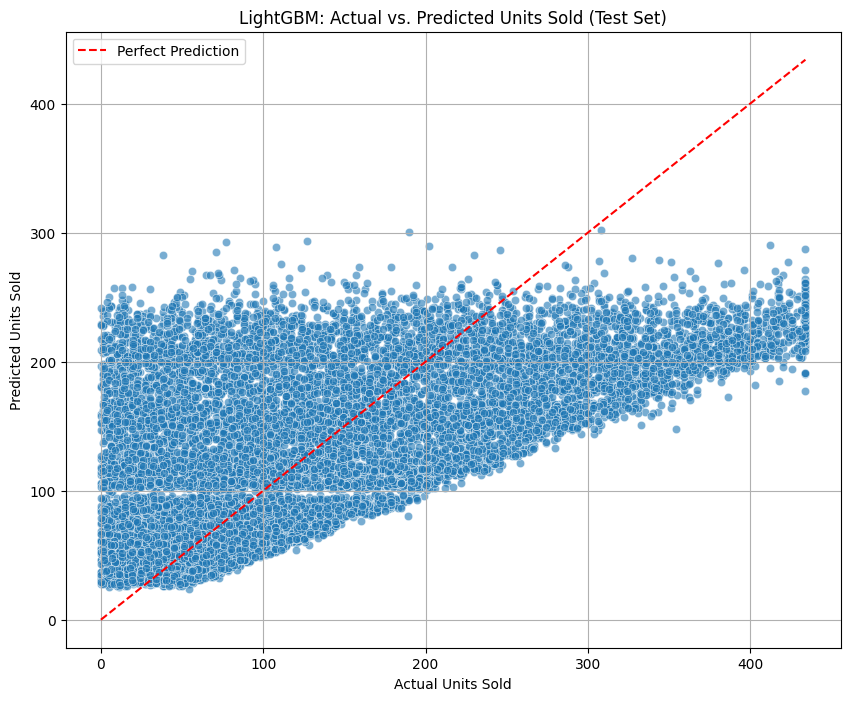

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_test_pred_lgb, alpha=0.6)

# Add a diagonal line for perfect predictions
min_val = min(y_test.min(), y_test_pred_lgb.min())
max_val = max(y_test.max(), y_test_pred_lgb.max())
x_values = np.linspace(min_val, max_val, 100)
plt.plot(x_values, x_values, color='red', linestyle='--', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Actual Units Sold')
plt.ylabel('Predicted Units Sold')
plt.title('LightGBM: Actual vs. Predicted Units Sold (Test Set)')
plt.legend()
plt.grid(True)
plt.show()